# Online Payments Fraud Detection

The dataset is used from the Kaggle website (https://www.kaggle.com/datasets/vardhansiramdasu/fraudulent-transactions-prediction).

The below column reference:

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount - amount of the transaction in local currency.

- nameOrig - customer who started the transaction

- oldbalanceOrg - initial balance before the transaction

- newbalanceOrig - new balance after the transaction

- nameDest - customer who is the recipient of the transaction

- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


In [24]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn

%matplotlib inline
plt.style.use('seaborn')

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# Import the dataset

df_original = pd.read_csv('online-payment.csv')

In [3]:
# Copy original dataset
df = df_original.copy()

In [64]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,4,9839.64,757870,170136.00,160296.36,1662095,0.00,0.00,0,0
1,1,4,1864.28,2188999,21249.00,19384.72,1733925,0.00,0.00,0,0
2,1,5,181.00,1002157,181.00,0.00,439686,0.00,0.00,1,0
3,1,2,181.00,5828263,181.00,0.00,391697,21182.00,0.00,1,0
4,1,4,11668.14,3445982,41554.00,29885.86,828920,0.00,0.00,0,0
5,1,4,7817.71,6026526,53860.00,46042.29,2247219,0.00,0.00,0,0
6,1,4,7107.77,1805948,183195.00,176087.23,2063364,0.00,0.00,0,0
7,1,4,7861.64,2999172,176087.23,168225.59,2314009,0.00,0.00,0,0
8,1,4,4024.36,869141,2671.00,0.00,768941,0.00,0.00,0,0
9,1,3,5337.77,5407277,41720.00,36382.23,282961,41898.00,40348.79,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
pd.set_option('display.float_format', '{:.2f}'.format) # To see actual values from describe() function

In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [7]:
# examining missing values distbrution
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


There are no missing values

In [8]:
# Normalized value counts
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

Out of all 635k data points, there are only 8213 has fraud transactions. This indicates that the dataset has imbalanced distribution of target variable. In order to solve the imbalanced target variable distribution by using **Synthetic Minority Oversampling Technique** or **SMOTE**. 

Source : https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

## EDA (Exploratory Data Analysis)

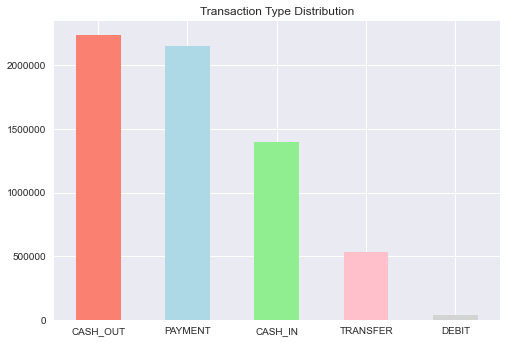

In [9]:
df['type'].value_counts().plot(kind='bar', color = ['salmon', 'lightblue', 'lightgreen', 'pink', 'lightgrey'])
plt.xticks(rotation=0)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Transaction Type Distribution');

`Cash out`, `Payment`, & `Cash` in transaction types are the majority of the online transaction dataset.

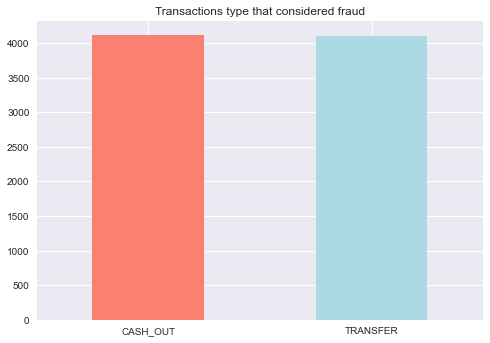

In [10]:
fraud_1 = df[df['isFraud'] == 1]

fraud_1['type'].value_counts().plot(kind='bar', color=['salmon', 'lightblue'])
plt.xticks(rotation=0)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Transactions type that considered fraud');

Mostly, transaction types that has the most at risk of being a fraud are `Cash out` & `transfer` type

### Convert Categorical into Numerical Variables

In [12]:
# Check columns which *aren't* numeric
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

type
nameOrig
nameDest


In [13]:
# Turn categorical variables into numbers
for label, content in df.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # We add the +1 because pandas encodes missing categories as -1
        df[label] = pd.Categorical(content).codes+1

## Check Correlation between Columns

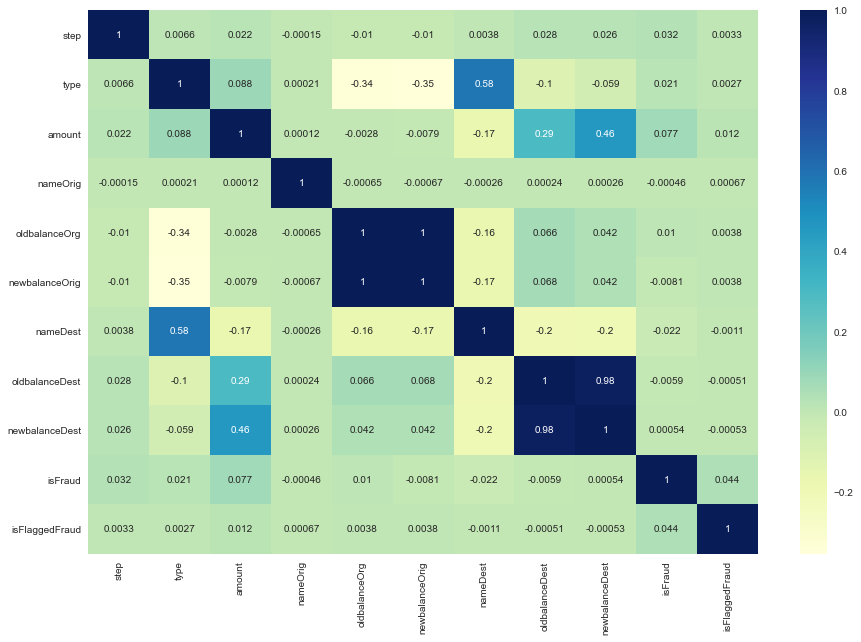

In [14]:
#Correlation Analysis
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap="YlGnBu");

### Split X and Y

In [15]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

### Use SMOTE to solve imbalanced target classification

In [17]:
from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [20]:
y.value_counts()

0    6354407
1    6354407
Name: isFraud, dtype: int64

### Data Normalization

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x = scaler.fit_transform(X)

### Split Train & Test Dataset

I decided to split train & test set for 50:50 due to many data

In [23]:
from sklearn.model_selection import train_test_split

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(x, # independent variables 
                                                    y, # dependent variable
                                                    test_size = 0.5, # percentage of data to use for test set
                                                    random_state=69) # random_set to get code producibility 

### Logistic Regression

In [41]:
#Set random seed for reproducibility
np.random.seed(69)

model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9173058949481832

In [42]:
# Import cross_val_score
from sklearn.model_selection import cross_val_score

np.random.seed(69)

# Cross-validated accuracy score
cv_acc = cross_val_score(model,
                         X,
                         y,
                         cv=5, # 5-fold cross-validation
                         scoring="accuracy") # accuracy as scoring
cv_acc

array([0.93806071, 0.95203093, 0.94451214, 0.94634157, 0.91517853])

In [50]:
# The average of 5-fold cross validation
np.mean(cv_acc)

0.9392247754946883

In [43]:
# Predict test set
y_pred = model.predict(X_test)

In [44]:
# Display confusion matrix
print(confusion_matrix(y_test, y_pred))

[[2978398  199895]
 [ 325577 2850537]]


In [46]:
# Show classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92   3178293
           1       0.93      0.90      0.92   3176114

    accuracy                           0.92   6354407
   macro avg       0.92      0.92      0.92   6354407
weighted avg       0.92      0.92      0.92   6354407



### ROC Curve & Score

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score

#Infer the class probabilities by using predict_proba()
y_score = model.predict_proba(X_test)[:,1]

#Creating False and True Positive Rates and printing Scores
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

print('roc_auc_score: ', roc_auc_score(y_test, y_score))

roc_auc_score:  0.9771436390790261


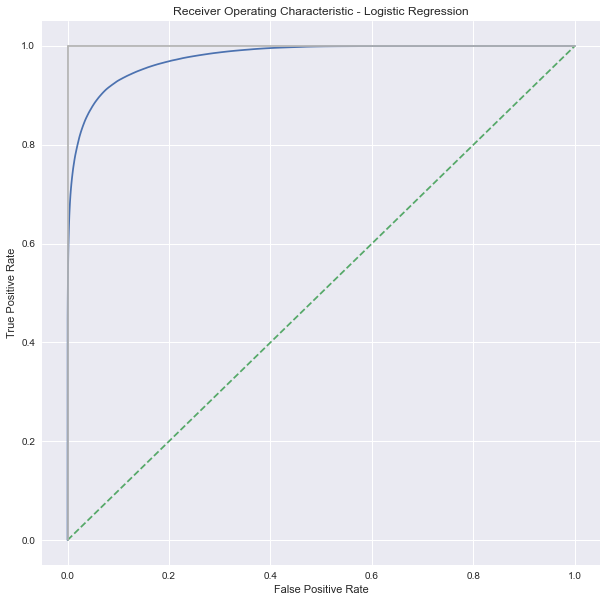

In [48]:
# Plot ROC Curve
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Feature Importance

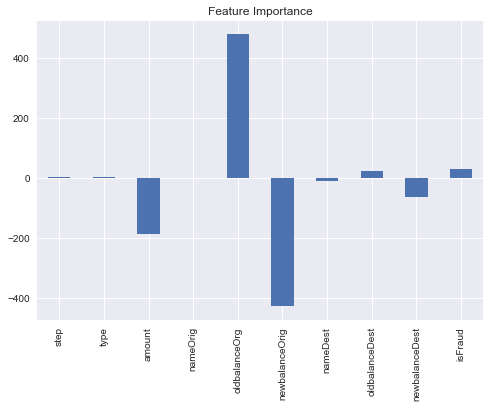

In [62]:
# Check coef_
model.coef_

# Match features to columns
features_dict = dict(zip(df.columns, list(model.coef_[0])))
features_dict

# Visualize feature importance
features_df = pd.DataFrame(features_dict, index=[0])
features_df.T.plot.bar(title="Feature Importance", legend=False);

Based on the plot, we can see some features that has high positive/negative values that correlates with `isFraud` variable. In this case, `oldbalanceOrig` has a strong positive correlation with `isFraud` which means that the higher value the initial balance before the transactions the higher possibility it is detected as a fraud. In contrary, `newbalanceOrig` has a strong negative correlation with `isFraud`.

## Conclusion

In conclusion, I have managed to get the accuracy of 93.92% using Logistic Regression with 5-fold cross validation technique for Online Payments Fraud Detection. Based on the feature importance of the model, it seems that Initial balance of the customer before the transaction & new balance after the transaction correlates with the detection whether the online payments a fraud or not.